In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%aimport emc
%aimport kdimuon
%aimport spill

In [3]:
from emc import *
from kdimuon import *
from spill import *
import scipy as sp
import pandas as pd
from pandas import DataFrame, Series
from scipy import stats
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
# import seaborn as sns
import uncertainties as unc
from uncertainties import unumpy as unp

sys.path.append('../modules')
from targets import mc_target_dict

In [4]:
pylab.rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive sessionpylab.rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [5]:
font = {'family' : 'serif', 'weight': 'bold'}
matplotlib.rc('font', **font)

### Objectives
1. Create analysis schema and table
2. Get xT array and number of live protons for each target
3. Get histogram counts and error for each target
4. Get PDF's for each distribution
4. Subtract Empty from LD2 and LH2 counts, combine error
5. Use LH2 and LD2 data, proportions, to get Deuterium counts, error
6. Plot distributions for all targets, including LD2 / D2
7. Calculate ratio values, error values, plot

In [7]:
server = 'seaquel.physics.illinois.edu'
analysis_schema = 'user_dannowitz_mc_tracked_check'
mc_schema_list = ['mc_drellyan_LH2_M004_S002','mc_drellyan_LD2_M004_S002', 
                  'mc_drellyan_C_M004_S002','mc_drellyan_Fe_M004_S002',
                  'mc_drellyan_W_M004_S002']
analysis_table = 'mDimuon_mc_tracked_M004'
#fresh_start = False
fresh_start = True

In [8]:
dimuon_df = mc_get_analysis_data(server=server, 
                                 analysis_schema=analysis_schema, 
                                 mc_schema_list=mc_schema_list,
                                 analysis_table=analysis_table,
                                 fresh_start=fresh_start)                                          

156230 dimuons from source table.

111649 entries copied over with mass between 4.2 and 10 GeV and chisq<25
111647 dimuons: after 2 entries deleted for x-range cuts
93010 dimuons: after 18637 entries deleted for dimuon positional and momentum cuts
90850 dimuons: after 2160 Rows deleted for track-level cuts
83438 dimuons: after 7412 Rows deleted for dump radius cut
83438 dimuons total after all cuts.
156211 dimuons from source table.

111644 entries copied over with mass between 4.2 and 10 GeV and chisq<25
111643 dimuons: after 1 entries deleted for x-range cuts
92996 dimuons: after 18647 entries deleted for dimuon positional and momentum cuts
90891 dimuons: after 2105 Rows deleted for track-level cuts
83706 dimuons: after 7185 Rows deleted for dump radius cut
83706 dimuons total after all cuts.
154703 dimuons from source table.

110700 entries copied over with mass between 4.2 and 10 GeV and chisq<25
110697 dimuons: after 3 entries deleted for x-range cuts
88539 dimuons: after 22158 en

### Objectives:
1. Get counts and average kinematics per bin per target
2. Get yields per live proton

In [9]:
pos_to_targ = {1: {'target': 'LH2'},
               2: {'target': 'Empty'},
               3: {'target': 'LD2'},
               4: {'target': 'None'},
               5: {'target': 'Fe'},
               6: {'target': 'C'},
               7: {'target':'W'}}
pos_to_targ_df = pd.DataFrame(pos_to_targ).T
dimuon_df = pd.merge(dimuon_df, pos_to_targ_df, left_on='targpos', right_index=True)

In [98]:
dimuon_df.drop('weight_sq', axis=1, inplace=True)

In [55]:
dimuon_df['weight_sq'] = dimuon_df['weight'] ** 2; dimuon_df.head()

,dimuonID,runID,mass,xF,xB,xT,targpos,weight,target,weight_sq
0,0,11,5.219403,0.520165,0.643452,0.189309,1,0.000351,LH2,1.232282e-07
1,4,11,8.170731,0.726715,0.858020,0.349139,1,0.000002,LH2,5.385556e-12
2,6,11,6.168396,0.733165,0.822194,0.216736,1,0.000019,LH2,3.605992e-10
3,8,11,7.245674,0.679939,0.837255,0.318722,1,0.000005,LH2,2.327040e-11
4,9,11,5.487430,0.610031,0.717820,0.192873,1,0.000239,LH2,5.735612e-08


In [69]:
groups = dimuon_df[['mass', 'xF', 'xB', 'xT']].groupby(by=[dimuon_df.target,
                                                           pd.cut(dimuon_df.xT, 15)])

In [70]:
counts_df = pd.DataFrame(dimuon_df[['mass', 'xF', 'xB', 'xT','weight']].groupby(by=[dimuon_df.target,
                                                                                pd.cut(dimuon_df.xT,15)]).weight.sum())

In [71]:
unc_df = pd.DataFrame(dimuon_df[['mass', 'xF', 'xB', 'xT','weight_sq']].groupby(by=[dimuon_df.target,
                                                                                pd.cut(dimuon_df.xT,15)]).weight_sq.sum())
unc_df = unc_df.apply(np.sqrt, axis=0)

In [72]:
means_df = groups['mass', 'xF', 'xB', 'xT'].mean()

array([[1.9979631245400016+/-0.06063764341914698],
       [11.535573648560028+/-0.24476659081553875],
       [14.928405091989957+/-0.3388975456307583],
       [11.976539139220005+/-0.2995945316194354],
       [7.151450909400015+/-0.18629873750780704]], dtype=object)

In [79]:
means_df['counts'] = counts_df
means_df['unc'] = unc_df
means_df['normcounts'] = unp.uarray(means_df['counts'],means_df['unc'])

In [100]:
means_df.ix[['LH2','LD2']]

mass        xF        xB        xT     counts  \
target xT                                                                   
LD2    (0.0831, 0.121]  4.466603  0.829912  0.860121  0.109413   2.423741   
       (0.121, 0.159]   4.847681  0.733535  0.791654  0.140688  14.039959   
       (0.159, 0.196]   5.312684  0.661438  0.749232  0.177625  17.990116   
       (0.196, 0.234]   5.780160  0.609273  0.726255  0.215047  13.391880   
       (0.234, 0.271]   6.214779  0.562425  0.710093  0.252585   8.866662   
       (0.271, 0.309]   6.611746  0.516707  0.696871  0.289872   5.759534   
       (0.309, 0.347]   7.004704  0.474510  0.688319  0.327229   3.159964   
       (0.347, 0.384]   7.359844  0.430838  0.680576  0.364565   1.746306   
       (0.384, 0.422]   7.698437  0.386476  0.674047  0.401807   0.950115   
       (0.422, 0.459]   8.062610  0.351639  0.675276  0.439079   0.440103   
       (0.459, 0.497]   8.391746  0.313479  0.675716  0.475773   0.171563   
       (0.497, 0.534]   8.820694  0.301161  0.693019  0.511595   0.047123   
       (0.534, 0.572]   8.966345  0.220954  0.671643  0.546992   0.012634   
       (0.572, 0.61]    9.011474  0.115075  0.640583  0.582819   0.001218   
       (0.61, 0.647]    8.971350  0.023222  0.620964  0.623747   0.000112   
LH2    (0.0831, 0.121]  4.459482  0.829646  0.859964  0.109251   0.874324   
       (0.121, 0.159]   4.846420  0.733003  0.791222  0.140723   5.051992   
       (0.159, 0.196]   5.310700  0.660508  0.748432  0.177559   6.667723   
       (0.196, 0.234]   5.784064  0.609706  0.726655  0.215171   5.010626   
       (0.234, 0.271]   6.217191  0.563817  0.711212  0.252412   3.502266   
       (0.271, 0.309]   6.626871  0.519582  0.698862  0.289939   2.416324   
       (0.309, 0.347]   7.006556  0.474627  0.688484  0.327396   1.573552   
       (0.347, 0.384]   7.363348  0.430317  0.680297  0.364807   0.926570   
       (0.384, 0.422]   7.706911  0.388296  0.675490  0.401692   0.477808   
       (0.422, 0.459]   8.067682  0.353902  0.676984  0.438876   0.220933   
       (0.459, 0.497]   8.406310  0.316819  0.678040  0.475467   0.102093   
       (0.497, 0.534]   8.720069  0.273513  0.677591  0.511933   0.029660   
       (0.534, 0.572]   9.013542  0.227947  0.678608  0.547801   0.006292   
       (0.572, 0.61]    9.387914  0.178770  0.682912  0.583291   0.000203   

                             unc         normcounts  
target xT                                            
LD2    (0.0831, 0.121]  0.068803        2.42+/-0.07  
       (0.121, 0.159]   0.292692       14.04+/-0.29  
       (0.159, 0.196]   0.396449         18.0+/-0.4  
       (0.196, 0.234]   0.319694       13.39+/-0.32  
       (0.234, 0.271]   0.226541        8.87+/-0.23  
       (0.271, 0.309]   0.159535        5.76+/-0.16  
       (0.309, 0.347]   0.097779        3.16+/-0.10  
       (0.347, 0.384]   0.062929        1.75+/-0.06  
       (0.384, 0.422]   0.041531        0.95+/-0.04  
       (0.422, 0.459]   0.025905      0.440+/-0.026  
       (0.459, 0.497]   0.014059      0.172+/-0.014  
       (0.497, 0.534]   0.006395      0.047+/-0.006  
       (0.534, 0.572]   0.003030    0.0126+/-0.0030  
       (0.572, 0.61]    0.000652    0.0012+/-0.0007  
       (0.61, 0.647]    0.000110  0.00011+/-0.00011  
LH2    (0.0831, 0.121]  0.024876      0.874+/-0.025  
       (0.121, 0.159]   0.105887        5.05+/-0.11  
       (0.159, 0.196]   0.145431        6.67+/-0.15  
       (0.196, 0.234]   0.118235        5.01+/-0.12  
       (0.234, 0.271]   0.094862        3.50+/-0.09  
       (0.271, 0.309]   0.067454        2.42+/-0.07  
       (0.309, 0.347]   0.048333        1.57+/-0.05  
       (0.347, 0.384]   0.034335      0.927+/-0.034  
       (0.384, 0.422]   0.020486      0.478+/-0.020  
       (0.422, 0.459]   0.012564      0.221+/-0.013  
       (0.459, 0.497]   0.008194      0.102+/-0.008  
       (0.497, 0.534]   0.004278      0.030+/-0.004  
       (0.534, 0.572]   0.001949    0.0063+/-0.0019  
       (0.572, 0.61]

In [10]:
emc_df, means_df = mc_emc_analysis(dimuon_df,5)

In [11]:
emc_df

,xT,D/H,C/D,Fe/D,Fe/D(iso),W/D,W/D(iso)
xT,,,,,,,
"(0.0831, 0.196]",0.1506871,1.168+/-0.024,0.916+/-0.019,0.971+/-0.020,0.961+/-0.020,1.015+/-0.021,0.987+/-0.022
"(0.196, 0.309]",0.2508888,1.095+/-0.023,0.948+/-0.021,0.986+/-0.022,0.980+/-0.022,1.018+/-0.022,1.001+/-0.024
"(0.309, 0.422]",0.3582112,0.840+/-0.025,0.954+/-0.030,0.992+/-0.030,1.006+/-0.032,0.930+/-0.029,0.967+/-0.034
"(0.422, 0.534]",0.4602627,0.80+/-0.05,0.86+/-0.06,0.95+/-0.06,0.96+/-0.07,0.80+/-0.05,0.85+/-0.06
"(0.534, 0.647]",0.5523706,0.92+/-0.34,0.89+/-0.33,0.91+/-0.28,0.92+/-0.29,1.2+/-0.5,1.3+/-0.6


In [15]:
bin_edges = [0.08, 0.14, 0.16, 0.18, 0.21, 0.25, 0.31, 0.53]
bin_centers = emc_df['xT'].values
lower_val = np.subtract(bin_centers,bin_edges[:-1])
upper_val = np.subtract(bin_edges[1:], bin_centers)
asymmetric_bars = [lower_val, upper_val]

In [12]:
bin_centers = emc_df['xT'].values

In [13]:
# Store the E772 results
e772_dict = {}
# DY Ratio for C/D vrs Xtgt - E772
# --------------------------------
e772_dict['C/D'] = {}
e772_dict['C/D']['bin_centers'] = [0.041, 0.062, 0.087, 0.111, 0.136, 0.161, 0.186, 0.216, 0.269]
e772_dict['C/D']['uratio'] = unp.uarray([0.981, 0.974, 1.013, 1.011, 0.979, 1.049, 1.117, 1.151, 1.044],
                                        [0.017, 0.014, 0.016, 0.020, 0.027, 0.044, 0.074, 0.110, 0.202])

# DY Ratio for Fe/D vrs Xtgt - E772
# --------------------------------
e772_dict['Fe/D'] = {}
e772_dict['Fe/D']['bin_centers'] = [0.041, 0.062, 0.087, 0.111, 0.136, 0.161, 0.186, 0.219, 0.271]
e772_dict['Fe/D']['uratio'] = unp.uarray([0.954, 0.976, 1.009, 0.992, 0.984, 1.009, 0.953, 1.016, 0.984],
                                         [0.014, 0.011, 0.012, 0.014, 0.018, 0.027, 0.037, 0.050, 0.088])

# DY Ratio for W/D vrs Xtgt - E772
# --------------------------------
e772_dict['W/D'] = {}
e772_dict['W/D']['bin_centers'] = [0.041, 0.062, 0.087, 0.111, 0.136, 0.161, 0.186, 0.216, 0.269]
e772_dict['W/D']['uratio'] = unp.uarray([0.954, 0.976, 1.009, 0.992, 0.984, 1.009, 0.953, 1.016, 0.984],
                                         [0.016, 0.013, 0.016, 0.020, 0.026, 0.043, 0.067, 0.099, 0.192])

In [14]:
title_string = r'$\frac{Yield_{%s}}{s \cdot \rho_{%s} \cdot L_{%s} \cdot A_{%s}}$ / ' + \
          r'$\frac{Yield_{%s}}{s \cdot \rho_{%s} \cdot L_{%s} \cdot A_{%s}}$'

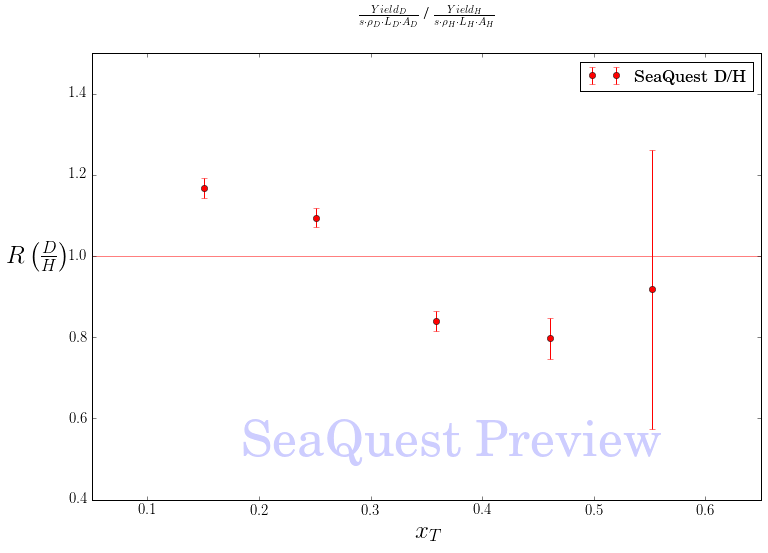

In [15]:
fig, ax = plt.subplots()

target2 = 'D'
target1 = 'H'

ax.errorbar(bin_centers, unp.nominal_values(emc_df['D/H'].values),
             yerr=unp.std_devs(emc_df['D/H'].values),
             fmt='o', color='red', label='SeaQuest ' + target2 + '/' + target1)

ax.set_xlabel(r'$x_T$', fontsize=25)
ax.set_ylabel(r'$R \left(\frac{' + target2 + r'}{' + target1 + r'}\right)$', fontsize=25, rotation=0, labelpad=30)
ax.set_title(title_string % (target2, target2, target2, target2, target1, target1, target1, target1),
          fontsize=16, y=1.05)

# position bottom right
fig.text(0.95, 0.05, 'SeaQuest Preview',
         fontsize=50, color='blue',
         position=(0.3, 0.2), alpha=0.2)

#ax.subplots_adjust(top=0.85)
ax.axhline(y=1, c='red', linewidth=0.5)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.axis((0.05, 0.65, 0.4, 1.5))
ax.legend(loc='best', fontsize=17)
# plt.savefig(target1 + "-" + target2 + ".pdf")

plt.show()

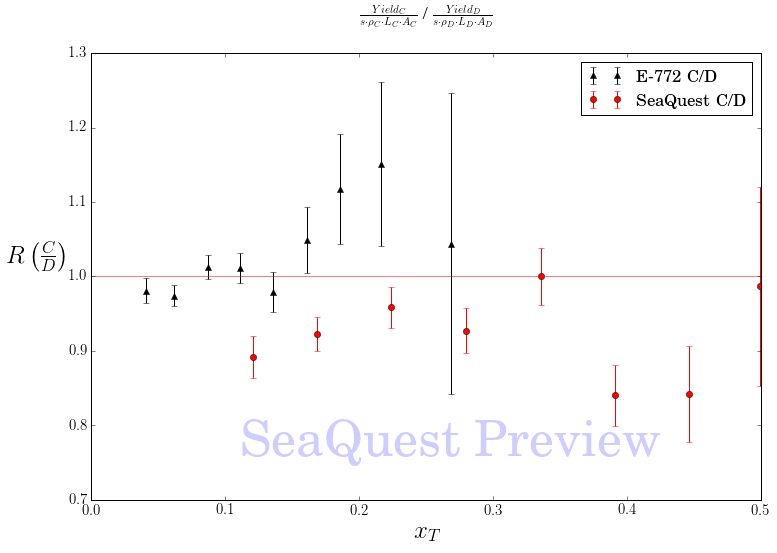

In [115]:
fig, ax = plt.subplots()

target2 = 'C'
target1 = 'D'

ax.errorbar(e772_dict['C/D']['bin_centers'], unp.nominal_values(e772_dict['C/D']['uratio']),
            unp.std_devs(e772_dict['C/D']['uratio']), fmt='^', color='black', label='E-772 C/D') 
ax.errorbar(bin_centers, unp.nominal_values(emc_df['C/D'].values),
            yerr=unp.std_devs(emc_df['C/D'].values),
            fmt='o', color='red', label='SeaQuest C/D')

ax.set_xlabel(r'$x_T$', fontsize=25)
ax.set_ylabel(r'$R \left(\frac{' + target2 + r'}{' + target1 + r'}\right)$', fontsize=25, rotation=0, labelpad=30)
ax.set_title(title_string % (target2, target2, target2, target2, target1, target1, target1, target1),
          fontsize=16, y=1.05)

# position bottom right
fig.text(0.95, 0.05, 'SeaQuest Preview',
         fontsize=50, color='blue',
         position=(0.3, 0.2), alpha=0.2)

#ax.subplots_adjust(top=0.85)
ax.axhline(y=1, c='red', linewidth=0.5)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.axis((0, 0.5, 0.7, 1.3))
ax.legend(loc='best', fontsize=17)
# plt.savefig(target1 + "-" + target2 + ".pdf")

plt.show()

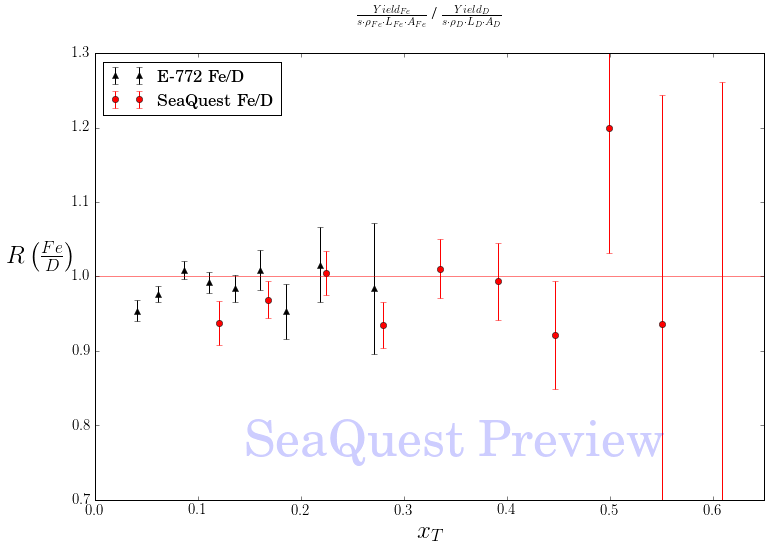

In [117]:
fig, ax = plt.subplots()

target2 = 'Fe'
target1 = 'D'

ax.errorbar(e772_dict['Fe/D']['bin_centers'], unp.nominal_values(e772_dict['Fe/D']['uratio']),
            unp.std_devs(e772_dict['Fe/D']['uratio']), fmt='^', color='black', label='E-772 Fe/D') 
ax.errorbar(bin_centers, unp.nominal_values(emc_df['Fe/D(iso)'].values),
             yerr=unp.std_devs(emc_df['Fe/D(iso)'].values), fmt='o', color='red', label='SeaQuest Fe/D')

ax.set_xlabel(r'$x_T$', fontsize=25)
ax.set_ylabel(r'$R \left(\frac{' + target2 + r'}{' + target1 + r'}\right)$', fontsize=25, rotation=0, labelpad=30)
ax.set_title(title_string % (target2, target2, target2, target2, target1, target1, target1, target1),
          fontsize=16, y=1.05)

# position bottom right
fig.text(0.95, 0.05, 'SeaQuest Preview',
         fontsize=50, color='blue',
         position=(0.3, 0.2), alpha=0.2)

#ax.subplots_adjust(top=0.85)
ax.axhline(y=1, c='red', linewidth=0.5)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.axis((0.0, 0.65, 0.7, 1.3))
ax.legend(loc='best', fontsize=17)
# plt.savefig(target1 + "-" + target2 + ".pdf")

plt.show()

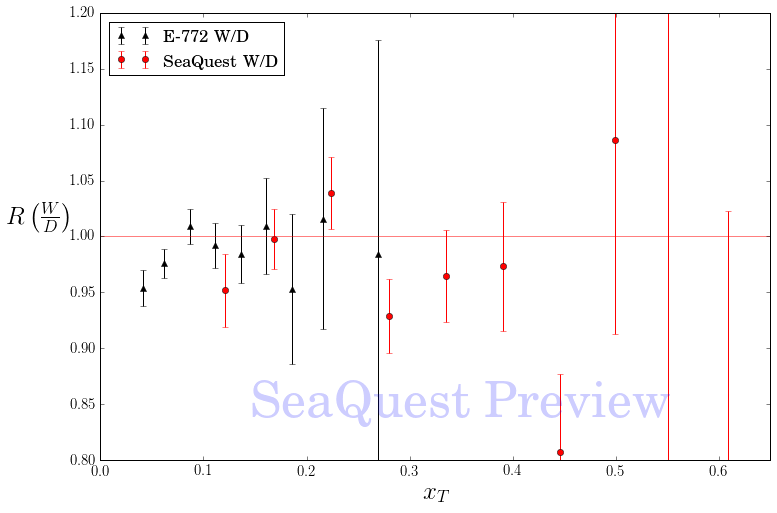

In [118]:
fig, ax = plt.subplots()

target2 = 'W'
target1 = 'D'

ax.errorbar(e772_dict['W/D']['bin_centers'], unp.nominal_values(e772_dict['W/D']['uratio']),
            unp.std_devs(e772_dict['W/D']['uratio']), fmt='^', color='black', label='E-772 W/D') 
ax.errorbar(bin_centers, unp.nominal_values(emc_df['W/D(iso)'].values),
             yerr=unp.std_devs(emc_df['W/D(iso)'].values), fmt='o', color='red', label='SeaQuest W/D')

ax.set_xlabel(r'$x_T$', fontsize=25)
ax.set_ylabel(r'$R \left(\frac{' + target2 + r'}{' + target1 + r'}\right)$', fontsize=25, rotation=0, labelpad=30)
#ax.set_title(title_string % (target2, target2, target2, target2, target1, target1, target1, target1),
#          fontsize=16, y=1.05)

# position bottom right
fig.text(0.95, 0.05, 'SeaQuest Preview',
         fontsize=50, color='blue',
         position=(0.3, 0.2), alpha=0.2)

#ax.subplots_adjust(top=0.85)
ax.axhline(y=1, c='red', linewidth=0.5)
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
ax.axis((0, 0.65, 0.8, 1.2))
ax.legend(loc='best', fontsize=17)
# plt.savefig(target1 + "-" + target2 + ".pdf")

plt.show()

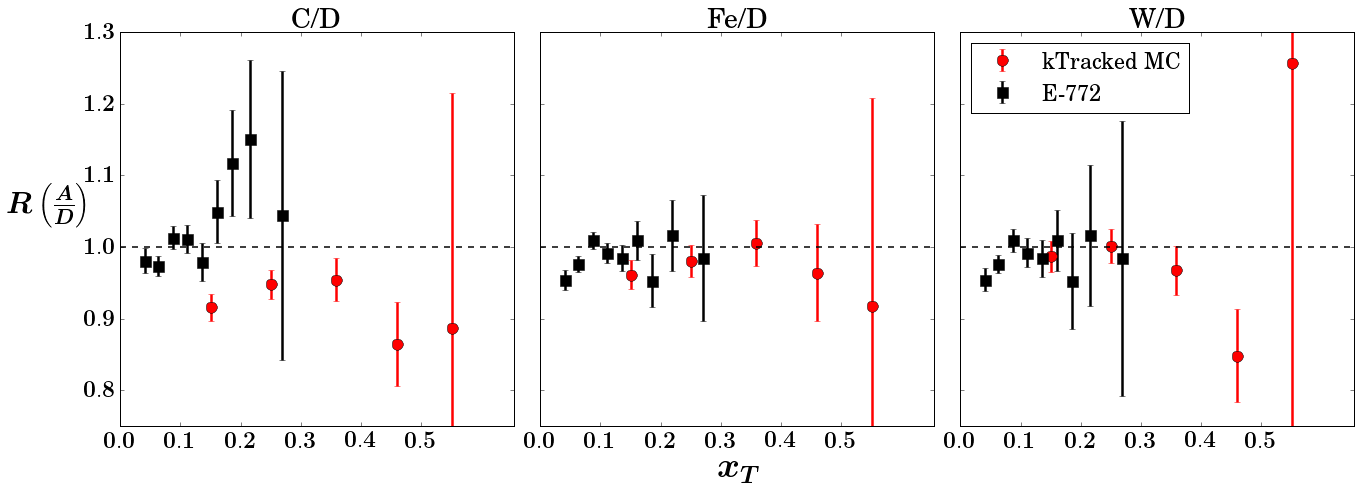

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(19,7))


ax1.set_title('C/D', fontsize=28)
ax1.errorbar(e772_dict['C/D']['bin_centers'], unp.nominal_values(e772_dict['C/D']['uratio']),
            unp.std_devs(e772_dict['C/D']['uratio']), fmt='s', ms=11, elinewidth=2.5, color='black', label='E-772 C/D') 
ax1.errorbar(bin_centers, unp.nominal_values(emc_df['C/D'].values),
             yerr=unp.std_devs(emc_df['C/D'].values),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='SeaQuest C/D')
ax1.axhline(y=1, c='black', ls='--', linewidth=1.5)
ax1.set_ylabel(r'$\boldsymbol{R \left(\frac{A}{D}\right)}$', fontsize=30, rotation=0, labelpad=35)
plt.setp(ax1.get_xticklabels(), fontsize=23)
plt.setp(ax1.get_yticklabels(), fontsize=23)

ax2.set_title('Fe/D', fontsize=28)
ax2.errorbar(e772_dict['Fe/D']['bin_centers'], unp.nominal_values(e772_dict['Fe/D']['uratio']),
            unp.std_devs(e772_dict['Fe/D']['uratio']), fmt='s', ms=11, elinewidth=2.5, color='black', label='E-772 Fe/D') 
ax2.errorbar(bin_centers, unp.nominal_values(emc_df['Fe/D(iso)'].values),
             yerr=unp.std_devs(emc_df['Fe/D(iso)'].values),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='SeaQuest Fe/D')
ax2.set_xlabel(r'$\boldsymbol{x_T}$', fontsize=35)
ax2.axhline(y=1, c='black', ls='--', linewidth=1.5)
plt.setp(ax2.get_xticklabels(), fontsize=23)

ax3.set_title('W/D', fontsize=28)
ax3.errorbar(bin_centers, unp.nominal_values(emc_df['W/D(iso)'].values),
             yerr=unp.std_devs(emc_df['W/D(iso)'].values), 
             fmt='o', ms=11, elinewidth=2.5, color='red', label='kTracked MC')
ax3.errorbar(e772_dict['W/D']['bin_centers'], unp.nominal_values(e772_dict['W/D']['uratio']),
            unp.std_devs(e772_dict['W/D']['uratio']), fmt='s', ms=11, elinewidth=2.5, color='black', label='E-772') 
ax3.axhline(y=1, c='black', ls='--', linewidth=1.5)
ax3.legend(loc='best', fontsize=22, numpoints=1)
plt.setp(ax3.get_xticklabels(), fontsize=23)

xtick_locs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
ytick_locs = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plt.xticks(xtick_locs, [r"$\mathbf{%.1f}$" % x for x in xtick_locs]) 
plt.yticks(ytick_locs, [r"$\mathbf{%.1f}$" % x for x in ytick_locs]) 

ax3.axis((0, 0.654, 0.75, 1.3))

plt.tight_layout()
plt.setp([a.get_yticklabels() for a in f.axes[1:]], visible=False)
plt.setp([a.get_xticklines() for a in f.axes[:]], lw=20)
plt.show()